Lecture Notes

- Most of the models in this chapter is for single predictor. However, high-dim models exist.

1. Polynomial Regression
- f(x)
- apply LS or logistic regression with X,X^2,...X^d predictors
- Estimate the pointwise variance of f(x): compute pointwise confidence interval by using the covariance matrix of the coefs.

2. Step Functions
- cutpoints, dummy variables
- apply LS or logistic regression with dummy variables
- coefs are the averages of Y for each subdomain 

3. Regression Spline
- Degree-d regression spline: piecewise degree-d polynomial, whose d-1 derivative is continuous at each knot 
- Basis function
- Cubic spline with K knots: use K+3 predictors (X,X^2,X^3 and K basis) with K+4 coef.(degree of freedom)
- Natual spline: regression spline which is linear at the boundary
- Use CV to determine the best K

4. Smoothing Splines
- Loss + penalty
- tuning parameter lambda controls the smoothness
- effective degrees of freedom (a measure of the flexibility of the smoothing spline)
    - Note: we don't use degrees of freedom as the parameters are heavily constrained by lambda
- There will be a knot at each training observation
- the fit function is a natural cubic spline (a shrunken version)
- Use CV to determine the best lambda

5. Local Regression
- fraction of training points: s
- weight function at each point: K
- fit a weighted LSR
- theoretically this can be implemented in higher dimensions
    - Note: training observations in the neighbors are very few for dim>3

6. Generalized Additive Methods (GAM)
- A way to extend MLR by replacing each linear component beta_i*Xi with a smooth nonlinear function
- Same idea for extending logistic regression
- Fitting method: backfitting (fitting partial residual)
- Pros
    - no need to transform variables
    - non-linear fits potentially make more accurate predictions
    - additive -> can examine the effect of X_i on Y individually
    - smoothness of each function can be summarized via degrees of freedom
- Cons
    - model is restricted to be additive. Important variable interations can be missed
        - can manually add interaction terms or interaction functions 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets,preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV

import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices, dmatrix

%matplotlib inline

In [45]:
data = pd.read_csv('data/Wage.csv',header=0)
data.head()
data = data.dropna().reset_index(drop=True)
X = pd.DataFrame(data.age)
Y = data.wage
Y_class = (Y>250).map({False:0,True:1}).as_matrix()

{'polynomialfeatures__degree': 4}
{'polynomialfeatures__degree': 1}
[[2921   79]
 [   0    0]]


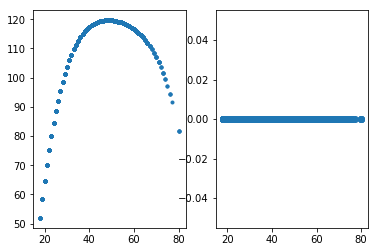

In [70]:
# Polynomial regression

# Use pipeline and GridSearchCV to find the best degree
model_pipe = make_pipeline(preprocessing.PolynomialFeatures(),LinearRegression())
n=list(np.arange(1,10))
est = GridSearchCV(model_pipe,dict(polynomialfeatures__degree=n),scoring='neg_mean_squared_error',cv=5)
est.fit(X,Y)
print(est.best_params_)
# Plot
fig,ax = plt.subplots(1,2)
ax[0].plot(X,est.predict(X),'.')


# Polynomial logistic regression
model_pipe = make_pipeline(preprocessing.PolynomialFeatures(),LogisticRegression())
n=list(np.arange(1,10))
est = GridSearchCV(model_pipe,dict(polynomialfeatures__degree=n),scoring='roc_auc',cv=5)
est.fit(X,Y_class)
print(est.best_params_)
print(confusion_matrix(est.predict(X),Y_class))
# Plot
ax[1].plot(X,est.predict(X),'o')
plt.show()

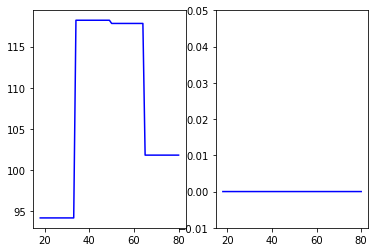

In [129]:
# Step function

# Sort
df = pd.concat([data.age,data.wage],keys=['age','wage'],axis=1)
df = df.sort_values(by='age')
# Cut
X_cut = pd.cut(df.age,4)
# Dummy variables
X_dummies = pd.get_dummies(X_cut)
X_dummies = X_dummies.drop(['(17.938, 33.5]'],axis=1)
Y_class = (df.wage>250).map({False:0,True:1}).as_matrix()
# Fit
stepfun = LinearRegression().fit(X_dummies,df.wage)
stepfun2 = LogisticRegression().fit(X_dummies,Y_class)
# Plot
fig,ax = plt.subplots(1,2)
ax[0].plot(df.age,stepfun.predict(X_dummies),'b')
ax[1].plot(df.age,stepfun2.predict(X_dummies),'b')
ax[1].set_ylim(-0.01,0.05)
plt.show()

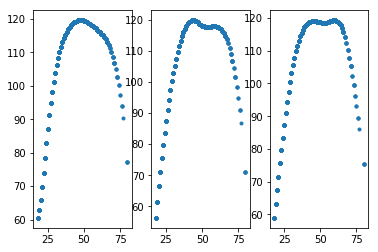

5


In [56]:
# Spline - patsy+sklearn

# Specify knots and degree
X1 = dmatrix("bs(age,knots=(25,40,60),degree=3,include_intercept=False)",{"age":data.age},return_type='dataframe')
fit1 = LinearRegression().fit(X1,Y)
# Knots at uniform quantiles with specific degrees of freedom
# defaul degree is 3. The num of knots is df-degree
X2 = dmatrix("bs(age,df=6,include_intercept=False)",{"age":data.age},return_type='dataframe')
fit2 = LinearRegression().fit(X2,Y)
# Natural spline
X3 = dmatrix("cr(age,df=6)",{"age":data.age},return_type='dataframe')
fit3 = LinearRegression().fit(X3,Y)
# plot
fig,ax = plt.subplots(1,3)
ax[0].plot(X,fit1.predict(X1),'.')
ax[1].plot(X,fit2.predict(X2),'.')
ax[2].plot(X,fit3.predict(X3),'.')
plt.show()

# CV for best degree
k_fold = 5
cv_score = [];
for i in np.arange(3,10):
    form = "cr(age,df="+str(i)+")"
    X4 = dmatrix(form,{"age":data.age},return_type='dataframe')
    model = LinearRegression()
    test = cross_val_score(model,X4,Y,cv=k_fold,scoring='neg_mean_squared_error',n_jobs=-1)
    cv_score.append(-test.mean())
print(np.array(cv_score).argmin()+3)


In [ ]:
# GAM
# https://github.com/dswah/pyGAM



In [48]:
type(cv_score)

list